In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten
import tensorflow as tf
import joblib
import shap
import matplotlib.pyplot as plt
import librosa.display

In [2]:
# Sabit özellik boyutu için parametreler
n_mfcc = 13
max_pad_len = 216

# Ses dosyalarının bulunduğu klasörün yolu --> Ana veri seti klasörü olacak
audio_folder = 'crema_tess'

# Fonksiyon: Dosya adından duygu bilgisini çıkarma
def get_label_from_filename(file):
    filename = os.path.basename(file)  # Dosya adını al
    emotion = filename.split('_')[2]   # Dosya adından duygu kısmını al
    return emotion

# Fonksiyon: Sabit boyutlu MFCC özelliklerini çıkarma
def extract_mfcc(file_path, n_mfcc=13, max_pad_len=216):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc

# Veri seti için boş listeler oluşturma
features = []
labels = []

# Ses dosyalarını işleme
for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):
        file_path = os.path.join(audio_folder, filename)
        
        # Sabit boyutlu MFCC özelliklerini çıkarma
        mfccs = extract_mfcc(file_path, n_mfcc=n_mfcc, max_pad_len=max_pad_len)
        
        flattened_features = np.ravel(mfccs)
        
        # Özellikleri listeye ekleme
        features.append(flattened_features)
        
        # Dosyanın duygu etiketini alarak labels listesine ekleme
        label = get_label_from_filename(file_path)
        labels.append(label)

# Verileri pandas DataFrame'e dönüştürme
df = pd.DataFrame(features)
df['labels'] = labels

# Verileri CSV dosyasına kaydetme
df.to_csv('audio_features.csv', index=False)

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['labels'])

# Verileri ve etiketleri ayırma
x = df.drop(columns=['labels']).values
y = y_encoded

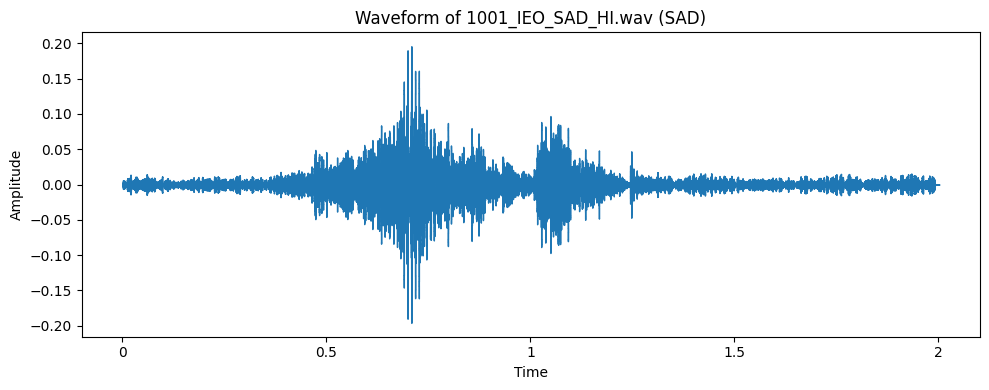

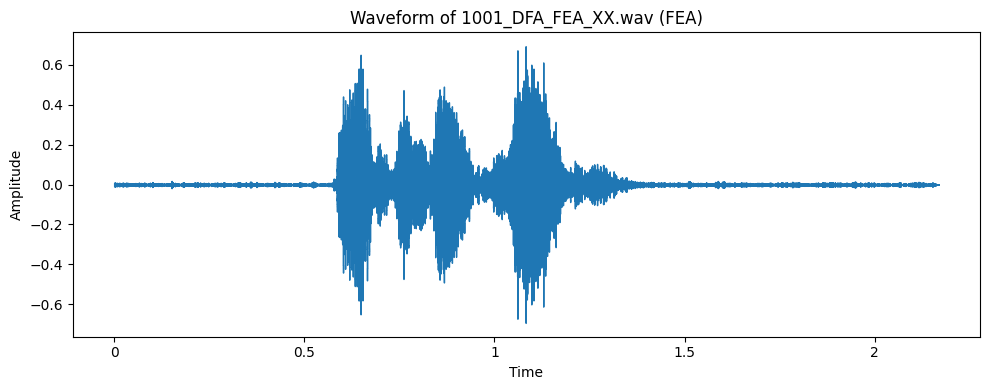

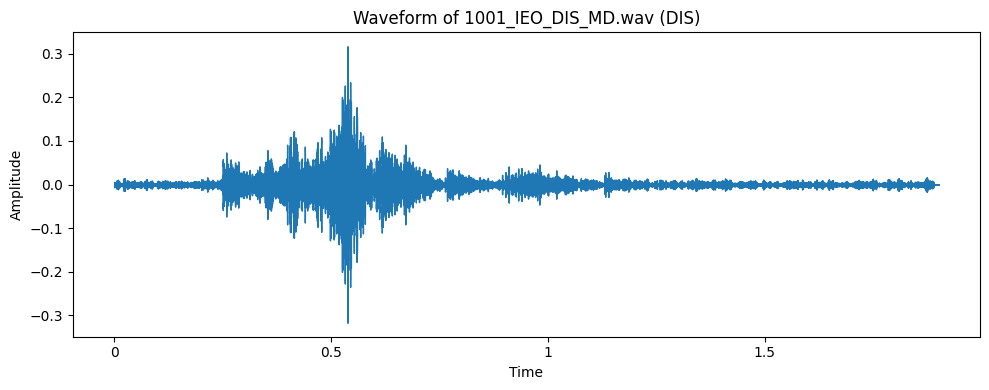

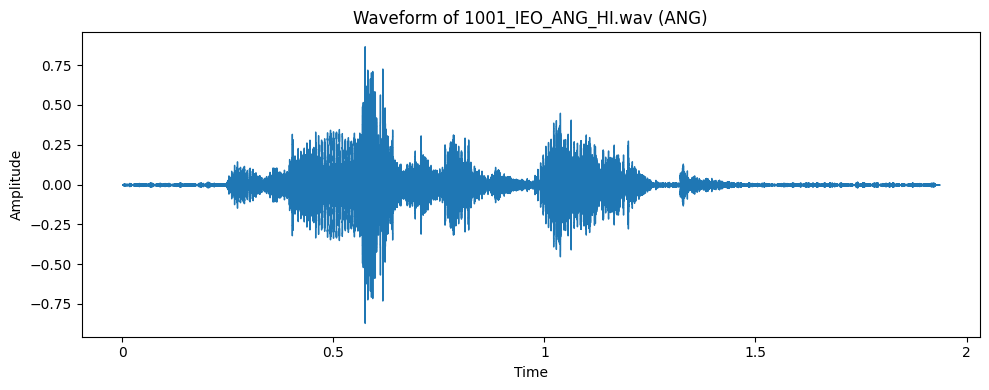

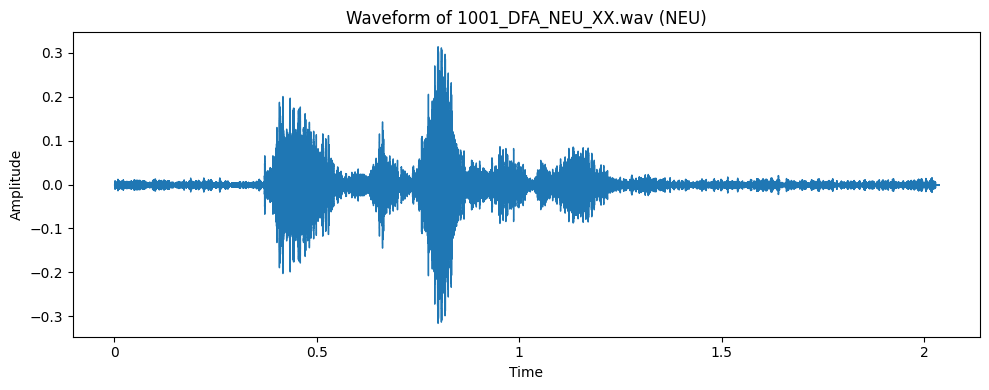

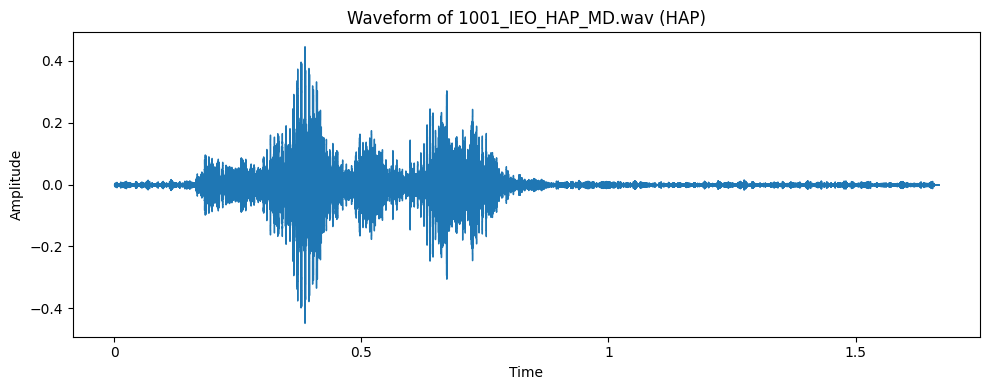

In [3]:
# Ses dosyalarının bulunduğu klasörün yolu
audio_samples = 'sample_audios'

# Duygular
emotions = ['SAD', 'FEA', 'DIS', 'ANG', 'NEU', 'HAP']

# Her duygu için örnek bir ses dosyası seçme
example_files = {emotion: None for emotion in emotions}

# Ses dosyalarını kontrol etme ve her duygudan bir örnek alma
for filename in os.listdir(audio_samples):
    if filename.endswith('.wav'):
        file_path = os.path.join(audio_samples, filename)
        emotion = filename.split('_')[2]  # Dosya adından duygu kısmını al
        if emotion in example_files and example_files[emotion] is None:
            example_files[emotion] = file_path

# Ses sinyallerini görselleştirme
def plot_audio_signal(audio_file, emotion):
    y, sr = librosa.load(audio_file, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform of {os.path.basename(audio_file)} ({emotion})')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Her duygunun örnek ses sinyalini görselleştirme
for emotion, file_path in example_files.items():
    if file_path:
        plot_audio_signal(file_path, emotion)
    else:
        print(f'{emotion} için örnek ses dosyası bulunamadı.')


In [4]:
# Verileri eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Verileri ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mevcut etiketlerinizi kontrol edin
unique_labels = np.unique(y_train)
print("Eğitim verilerindeki benzersiz etiketler:", unique_labels)

# Eğer etiketler 0-5 aralığında değilse, yeniden etiketleme yapın
# Örnek olarak, mevcut etiketlerinizi 0-5 aralığında yeniden etiketleyebilirsiniz
label_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 0, 7: 1, 8: 2, 9: 3, 10: 4, 11: 5}

y_train_mapped = np.array([label_mapping[label] for label in y_train])
y_test_mapped = np.array([label_mapping[label] for label in y_test])

# Tekrar benzersiz etiketleri kontrol edin
unique_labels_mapped = np.unique(y_train_mapped)
print("Yeniden etiketlenmiş eğitim verilerindeki benzersiz etiketler:", unique_labels_mapped)

# Model oluşturma
model = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # 6 sınıf için softmax çıkış katmanı
])

# Modeli derleme
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
model.fit(X_train_scaled, y_train_mapped, epochs=50, batch_size=32, validation_split=0.2)

# Modeli değerlendirme
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_mapped)
print('Test accuracy:', test_acc)

Eğitim verilerindeki benzersiz etiketler: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Yeniden etiketlenmiş eğitim verilerindeki benzersiz etiketler: [0 1 2 3 4 5]
Epoch 1/50
197/197 [==============================] - 4s 15ms/step - loss: 0.7677 - accuracy: 0.6685 - val_loss: 0.6955 - val_accuracy: 0.7003
Epoch 2/50
197/197 [==============================] - 3s 13ms/step - loss: 0.7314 - accuracy: 0.7485 - val_loss: 0.7185 - val_accuracy: 0.6876
Epoch 3/50
197/197 [==============================] - 3s 14ms/step - loss: 0.5130 - accuracy: 0.7955 - val_loss: 0.7147 - val_accuracy: 0.6933
Epoch 4/50
197/197 [==============================] - 3s 14ms/step - loss: 0.3820 - accuracy: 0.8473 - val_loss: 0.7557 - val_accuracy: 0.7041
Epoch 5/50
197/197 [==============================] - 3s 14ms/step - loss: 0.2714 - accuracy: 0.8977 - val_loss: 0.9632 - val_accuracy: 0.7029
Epoch 6/50
197/197 [==============================] - 3s 14ms/step - loss: 0.1871 - accuracy: 0.9382 - val_loss: 1.0157 - val_ac

In [5]:
# Modeli kaydetme
model.save('emotion_recognition_model.keras')

# Scaler ve label encoder'ı kaydetme
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

1/1 [==============================] - 0s 66ms/step


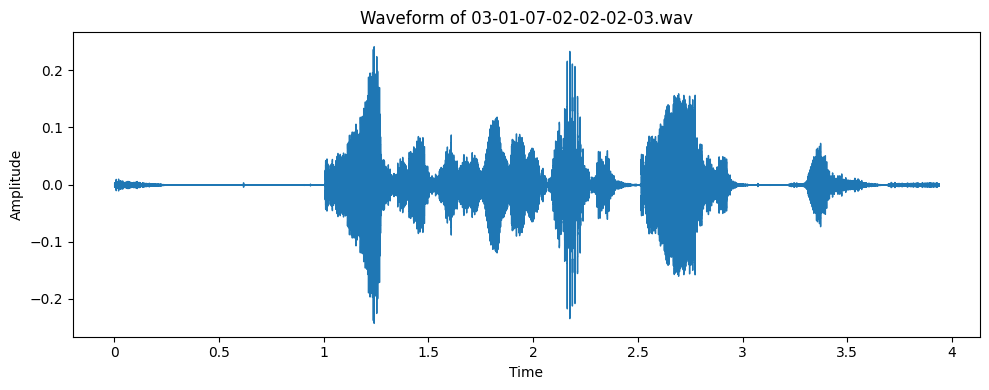

Predicted emotion: FEA.wav


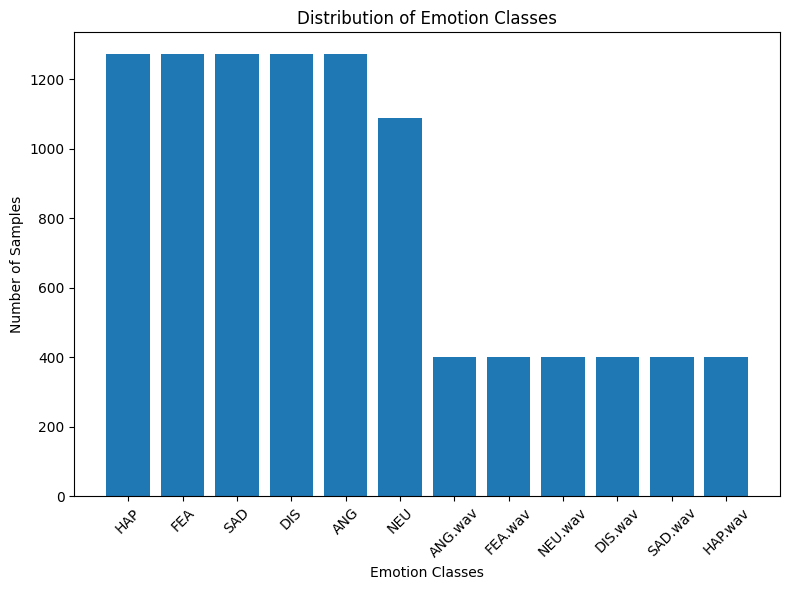

In [13]:
# Modeli yükleme ve tahmin yapma
def predict_emotion(audio_file):
    # Modeli yükleme
    model = load_model('emotion_recognition_model.keras')
    
    # Scaler ve label encoder'ı yükleme
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    
    # Sabit boyutlu MFCC özelliklerini çıkarma
    mfccs = extract_mfcc(audio_file, n_mfcc=n_mfcc, max_pad_len=max_pad_len)
    
    flattened_features = np.ravel(mfccs)
    
    # Özellikleri ölçeklendirme
    scaled_features = scaler.transform([flattened_features])
    
    # Tahmin yapma
    predictions = model.predict(scaled_features)
    predicted_label = np.argmax(predictions, axis=1)
    
    # Tahmin edilen etiketi orijinal etiketle eşleştirme
    emotion = label_encoder.inverse_transform(predicted_label)
    
    # Ses sinyalini görselleştir
    plot_audio_signal(audio_file)
    
    return emotion[0]

# Ses sinyalini görselleştirme fonksiyonu
def plot_audio_signal(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform of {os.path.basename(audio_file)}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Örnek bir ses dosyasını tahmin etme ve sinyalini görselleştirme
audio_file = '/home/songul/Desktop/97lik/archive/Actor_03/03-01-07-02-02-02-03.wav'
predicted_emotion = predict_emotion(audio_file)
print(f'Predicted emotion: {predicted_emotion}')


"""
## -----> SHAP EXPLAINER <-----

# SHAP için explainer oluşturun
explainer = shap.Explainer(model, X_train_scaled, max_evals=3537)

# SHAP değerlerini hesaplayın
shap_values = explainer(X_test_scaled)

# Özellik isimlerini kontrol edin
feature_names = df.columns[:-1]
print(f"Feature names: {feature_names}")

# Özellik isimlerini numpy array'e dönüştürün
feature_names = np.array(feature_names)

# SHAP Plots
class_index = 3  # Görüntülemek istediğiniz sınıfın indeksi --> Duygu sınıfları
shap.summary_plot(shap_values[..., class_index], X_test_scaled, feature_names=feature_names, plot_type='bar')
"""


# Sınıf dağılımını hesapla
class_counts = df['labels'].value_counts()

# Sınıf dağılımını görselleştir
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Emotion Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()